# Аналіз ознак та оцінка побудованої моделі

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Аналіз ознак

In [2]:
import json
import torch

from explaining.attribution_visualizer import AttributionVisualizer
from explaining.utils import tokens_to_words, preprocess_text_to_tensor

from explaining.attribution_explainer import AttributionExplainer
from explaining.explain import load_all_artifacts, get_validation_inputs, prepare_embeddings, get_wrapper_and_tokens

from captum.attr import remove_interpretable_embedding_layer

from networks.utils.loader import load_model_state
from networks.model.lstm_classifier import FakeNewsLstmClassifier
from preprocessing.cleaning.text_cleaning import process_text_tokens

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def explain_single_example(idx=0, mode="title", device=DEVICE):
    assert mode in ["title", "text"], "mode must be 'title' or 'text'"

    embedding_path = "../registry/embeddings/embedding_matrix.pt"
    model_path = "../registry/models/lstm/fake_news_model.pt"
    data_path = "../registry/datasets/processed_dataset.pt"
    vocab_path = "../registry/vocabularies/vocab.json"

    model, data, index_to_word = load_all_artifacts(FakeNewsLstmClassifier, embedding_path, model_path, data_path, vocab_path)
    title_input_ids, text_input_ids, X_val_title, X_val_text = get_validation_inputs(data, idx, device)
    interpretable_emb, embedded_title, embedded_text = prepare_embeddings(model, title_input_ids, text_input_ids)
    wrapper, tokens, input_embedded, token_type = get_wrapper_and_tokens(
        model, embedded_title, embedded_text, X_val_title, X_val_text, idx, mode
    )

    wrapper.to(device).eval()

    explainer = AttributionExplainer(wrapper, interpretable_emb)
    attr = explainer.compute_attributions(input_embedded)
    remove_interpretable_embedding_layer(model, interpretable_emb)

    words = tokens_to_words(tokens, index_to_word)
    attr_scores = attr.norm(p=1, dim=1).cpu().numpy()

    visualizer = AttributionVisualizer()
    visualizer.show_colored_text(words, attr_scores, title=f"Важливість Tокенів для {token_type}")
    visualizer.plot_bar_chart(words, attr_scores, title=f"Top Важливих {token_type} Токенів")

Model loaded from C:\Users\altsh\PycharmProjects\fake_news_detection_assignment\registry\models\lstm\fake_news_model.pt to cuda


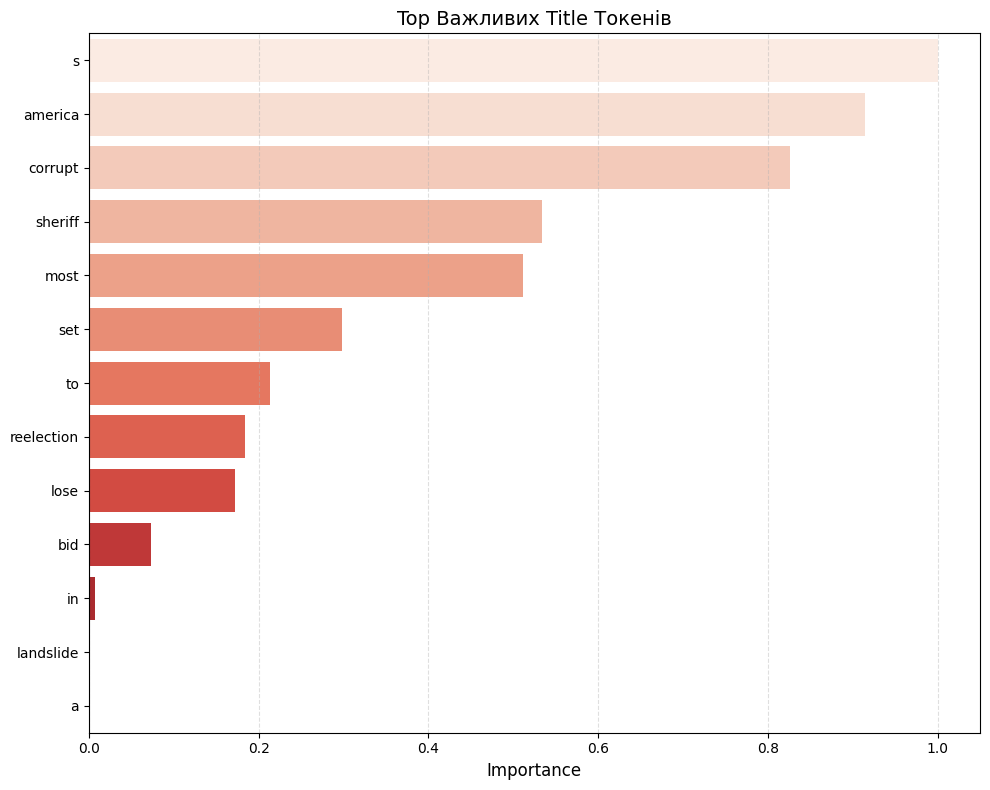

In [5]:
explain_single_example(idx=0, mode="title")

Спостереження:
Бачимо, що у випадку заголовків модель сконцентрувалась на більш емоційно забарвлених словах, що можуть бути використаними для створення сенсації.

Model loaded from C:\Users\altsh\PycharmProjects\fake_news_detection_assignment\registry\models\lstm\fake_news_model.pt to cuda


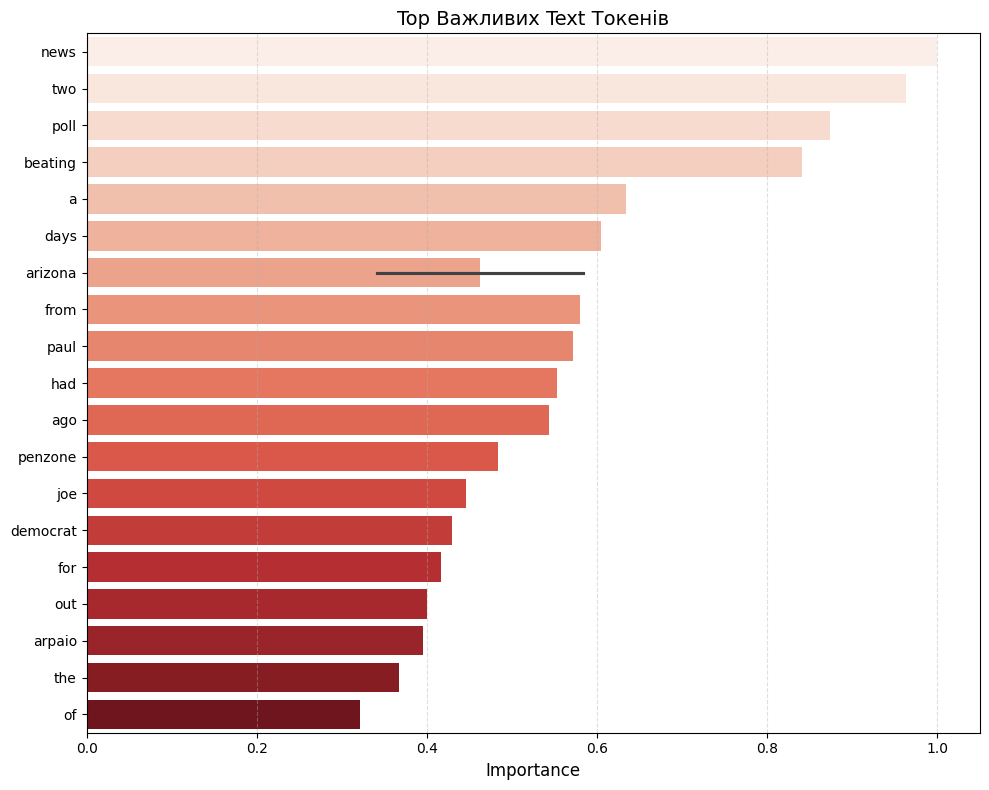

In [6]:
explain_single_example(idx=0, mode="text")

Спостереження:

Досить цікавим є набір найважливіших токенів з тексту: "two", "days", "ago". Можемо інтерпретувати це як те, що ці слова використовуються для створення враження терміновості, новизни, що може бути маркером фейкової новини.
Також згадуються політичні терміни "democrat", "republican", що можуть бути тригерами для моделі, оскільки ми знаємо з EDA, що у нас багато політичного контексту в нашому наборі даних де згадування таких слів часто зустрічається в фейкових новинах.



## Оцінка моделі

In [7]:
MAX_LEN_TITLE = 30
MAX_LEN_TEXT = 800

In [8]:
embedding_matrix = torch.load("../registry/embeddings/embedding_matrix.pt", map_location=DEVICE)
embedding_tensor = embedding_matrix.float().to(DEVICE)

with open("../registry/vocabularies/vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

model = load_model_state(
    FakeNewsLstmClassifier,
    embedding_tensor,
    path="../registry/models/lstm/fake_news_model.pt",
    device=DEVICE
)

Model loaded from C:\Users\altsh\PycharmProjects\fake_news_detection_assignment\registry\models\lstm\fake_news_model.pt to cuda


In [9]:
def text_to_sequence(text: str, vocab: dict, max_len: int) -> list:
    tokens = process_text_tokens(text)
    sequence = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(sequence) < max_len:
        sequence += [vocab["<PAD>"]] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    return sequence


In [10]:

def predict(model, title, text,
            vocab=vocab,
            max_len_title=MAX_LEN_TITLE,
            max_len_text=MAX_LEN_TEXT,
            device=DEVICE):
    title_tensor = preprocess_text_to_tensor(title, vocab, max_len_title, device, text_to_sequence)
    text_tensor = preprocess_text_to_tensor(text, vocab, max_len_text, device, text_to_sequence)

    for name, param in model.named_parameters():
        assert param.device.type == torch.device(device).type, \
            f"Параметр {name} не на {device}, а на {param.device}"

    model.eval()
    with torch.no_grad():
        output = model(title_tensor, text_tensor)
        prob = torch.sigmoid(output).item()
        predicted_class = int(prob > 0.5)

    # Вивід
    print(f"\nРезультат: {'Фейкова' if predicted_class else 'Справжня'} новина. Ймовірність фейковості: {prob:.2f}")


In [11]:
title = "Breaking: Earthquake in Chile"
text = "A strong earthquake struck the region..."
predict(model, title, text)


Результат: Справжня новина. Ймовірність фейковості: 0.44


Спостереження:

Бачимо, що ми можемо використати попередньо натреновану модель. Модель передбачає з високою впевненістю, що новина фейкова, що не є дивним, адже в прикладі використали достатньо емоційну лексику.

Спробуємо інший приклад.

Оскільки ми встановили, що набір даних має новини що співпадають у часі з проведенням виборчої команії в США в 2016 році, і також з EDA ми знаємо, що багато новин містять політичний контекст, і слово "trump" є дуже популярним як у заголовках так і у тексах новин, і так само як і в фейкових новинах, так і в правдивих. Тож спробуємо підібрати, щось із свіжих новин зі згадкою про Дональда Трампа.

Для прикладу візьмемо новину з ресурсу [aljazeera](https://www.aljazeera.com/news/2025/5/19/trumps-massive-tax-cut-bill-passes-key-us-house-committee-vote).

Дата публікації: 19 May 2025

Візьмемо частину новини:

> United States President Donald Trump’s sweeping tax-cut bill has won approval from a key congressional committee to advance towards possible passage in the House of Representatives later this week.
>The rare Sunday night vote marks a big win for Trump and House Speaker Mike Johnson, after hardline Republican conservatives on Friday blocked the bill from clearing the House Budget Committee over a dispute involving spending cuts to the Medicaid healthcare programme for lower-income Americans and the repeal of green energy tax credits.

In [12]:
title = "Trump’s massive tax cut bill passes key US House committee vote"
text = """United States President Donald Trump’s sweeping tax-cut bill has won approval from a key congressional committee to advance towards possible passage in the House of Representatives later this week.
The rare Sunday night vote marks a big win for Trump and House Speaker Mike Johnson, after hardline Republican conservatives on Friday blocked the bill from clearing the House Budget Committee over a dispute involving spending cuts to the Medicaid healthcare programme for lower-income Americans and the repeal of green energy tax credits.
"""

predict(model, title, text)


Результат: Справжня новина. Ймовірність фейковості: 0.01


Спостереження:

Басимо, що модель сприйняла дану модель як правдиву.

Спробуємо створити текст з набору токенів, що модель виявила для себе як найбільш впливовими.

In [13]:
title = "america s most corrupt sheriff set to lose reelection bid in a landslide"
text = "two days ago a poll from the arizona news had democrat paul penzone beating out republican joe arpaio for the"
predict(model, title, text)


Результат: Фейкова новина. Ймовірність фейковості: 1.00


Спостереження:

Бачимо, що модель дійсно класифікувала таку новину як фейк, що в цілому очікувано, адже цей приклад складається лише з найважливіших токенів.

Видумаємо якийсь текст, з використанням важливих токенів, так щоб структура виглядала достовірно, але сповнена емоційних та оціночних висловів, що підвищують ймовірність її класифікації як фейкової.

In [14]:
title = "Controversial Arizona sheriff Joe Arpaio loses"
text = "Just two days ago, a shocking new poll revealed that Democrat Paul Penzone is beating Republican Joe Arpaio by a historic margin in the Arizona sheriff’s race. According to the Arizona News Network, Penzone is expected to secure a landslide victory, marking the end of what many have called one of the most controversial tenures in American law enforcement history."
predict(model, title, text)


Результат: Фейкова новина. Ймовірність фейковості: 1.00


Спробуємо тепер взяти новину яка існує в реальному світі, а невигадана про цю ж особу Joe Arpaio.

Візьмемо новину з джерела [CNN](https://edition.cnn.com/2016/11/09/politics/arizona-sheriff-joe-arpaio-loses).


Дата публікації November 9, 2016 - що відповідає нашому періоду.

> Controversial Arizona sheriff Joe Arpaio loses
>Washington CNN — Joe Arpaio, the poster child for hardline immigration policy in the United States, has lost his reelection run for sheriff in Arizona’s largest county, according to an Associated Press projection. CNN is not independently projecting a winner for this race. Arpaio has served as the top cop in Phoenix’s Maricopa County for decades and was seeking his seventh term on Tuesday. But he lost to Democrat Paul Penzone, a former Phoenix policeman. Arpaio called himself “America’s toughest sheriff” and was known for his tough stance on immigration in the border state. His reelection run was imperiled, though, when a federal judge ordered him to be tried on a criminal contempt charge, accusing him of disobeying a court order in a racial-profiling case. A staunch supporter of Donald Trump, Arpaio has insisted that President Barack Obama is not a US citizen and that his birth certificate is fraudulent.


Як попередньо можемо бачити, дана новина містить певну кількість токенів за допомогою яких модель визначає, що новина є фейковою.

In [15]:
title = "America’s Most Corrupt Sheriff Set to Lose Reelection Bid in a Landslide"
text = """
Joe Arpaio, the poster child for hardline immigration policy in the United States, has lost his reelection run for sheriff in Arizona’s largest county, according to an Associated Press projection.

CNN is not independently projecting a winner for this race.

Arpaio has served as the top cop in Phoenix’s Maricopa County for decades and was seeking his seventh term on Tuesday. But he lost to Democrat Paul Penzone, a former Phoenix policeman.

Arpaio called himself “America’s toughest sheriff” and was known for his tough stance on immigration in the border state. His reelection run was imperiled, though, when a federal judge ordered him to be tried on a criminal contempt charge, accusing him of disobeying a court order in a racial-profiling case.
"""
predict(model, title, text)


Результат: Фейкова новина. Ймовірність фейковості: 1.00


Спостереження: Бачимо, що модель класифікувала новину як фейк. Вірогідно не можемо сказати, чи це реально є фейком, чи ні, адже ця новина існує. Отже, маємо два варіанти, або опублікована новина може бути фейковою, або побудована модель помилилась, таким чином, можемо припустити, що бачачи певний контекст модель може бути упередженою.

Спробуємо ускладнити моделі задачу, придумаємо псевдонаукову новину

In [16]:
title = "Scientists Confirm: The Earth Is Flat and the Sun Revolves Around It"
text = "In a groundbreaking report released by the International Astrophysics Consortium Terra Veritas researchers claim that the long-standing belief in a spherical Earth may be fundamentally flawed. According to the group, recent data from a newly developed 3D Analytical Spectroprobe indicates that the Earth is, in fact, flat — and that the Sun orbits above it in a precise, spiraling path."
predict(model, title, text)


Результат: Фейкова новина. Ймовірність фейковості: 1.00


Спостереження: бачимо, що модель справилась з завданням, і все ж таки визначила, що ця новина фейкова. Отже, модель навчилася сприймати сенсаційний, емоційно забарвлений контекс не лише у випадку політичної тематики.

Висновок:

- Модель зосереджує увагу на емоційно забарвлених, оціночних словах, які характерні для клікбейтових або маніпулятивних заголовків. Такі токени можуть також відображати політичну упередженість.
- Вона навчилася розпізнавати риторику фейкових новин, орієнтуючись на сенсаційні формулювання, що часто подаються як новини останньої хвилини. Ці елементи створюють відчуття актуальності, що є типовим прийомом для підвищення довіри до неправдивої інформації.

- Особливо значущими для моделі виявилися слова, які апелюють до емоцій читача або створюють конфліктні ситуації, наприклад: “most corrupt”, “landslide”, “set to lose” тощо.

- У тексті новини модель надала високу вагу політичним термінам і іменам: “democrat”, “republican”, “paul penzone”, “joe arpaio”. Це свідчить про те, що вона могла навчитися використовувати політичний контекст як ознаку фейковості — ймовірно, через часту появу таких шаблонів у тренувальному наборі.

Загалом, модель використовує як індикатори фейковості:
- емоційно-оціночну лексику
- термінові формулювання та новинні шаблони
- політичний контекст та згадки публічних осіб

Це свідчить про те, що модель схильна виявляти риторичні та стилістичні патерни, а не лише аналізувати змістовну суть тексту. Така поведінка може бути корисною в практичних задачах, однак вона також підкреслює необхідність додаткового аналізу на предмет упередженості моделі та перевірки її здатності узагальнювати на нові приклади.